# Fluorence of a two-level atom

### installing & loading packages

In [ ]:
using Pkg

Pkg.add("QuantumOptics")
Pkg.add("CairoMakie")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")
Pkg.add("FFTW")
Pkg.add("Plots")
# Pkg.update()

In [91]:
using QuantumOptics
using CairoMakie
using LaTeXStrings
using LinearAlgebra
using FFTW

import Plots as P
colors=P.palette(:tab10)

## 1) Finding the steady-state

We first define the usefull quantites and the Hamiltonian
$$
H=-\frac{\hbar\delta}{2}\sigma_z +\frac{\hbar\Omega}{2}(\sigma_+ + \sigma_-),
$$
where $ \hbar \omega_0$ is the energy betewen de ground and the excited state , $\omega_l$ is the laser frequency, $\delta =\omega_L - \omega_0$ is the detuning and $\Omega$ the Rabi frenquency.
For computational reason, we will set $\hbar=1$.

In [52]:
#basis
b = NLevelBasis(2)

#parameters
ω_L=1
ω_0=1
Ωs=[0,0.1, 1, 10]
δ=ω_L - ω_0

Γe=1

#Hamiltonian
σ_p=transition(b,2,1)
σ_m=transition(b,1,2)
σ_z=transition(b,2,2) - transition(b,1,1)

H(δ, Ω)=-(δ/2)*σ_z + (Ω/2)*(σ_p + σ_m)

#jump operators
J=[σ_m]

#rates  
rates=[Γe]

1-element Vector{Int64}:
 1

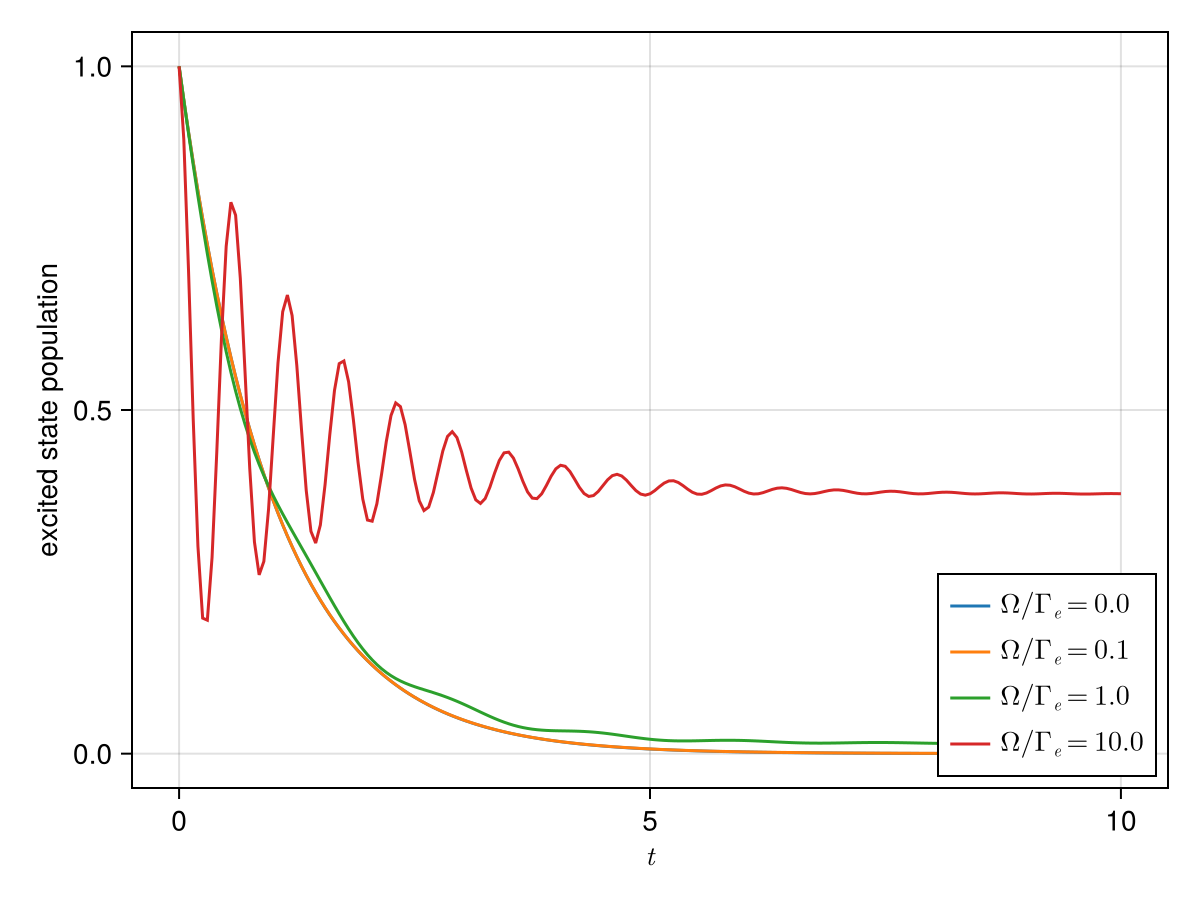

In [7]:
#initial state
ψ0 = nlevelstate(b,2)
# ρ0=tensor(ψ0,ψ0')

#time evolution
tspan = 0:0.05:10

#plot + computation
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"t", ylabel="excited state population")

for (i,Ω) in enumerate(Ωs)
    #time evolution
    tout, ψt=timeevolution.master(tspan,ψ0,H(δ, Ω),J,rates=rates)
    #expectation value
    exp_pt=real(expect(transition(b,2,2),ψt))
    #plotting
    lines!(ax, tspan, exp_pt, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[i])
end

axislegend(ax,position=:rb)
fig

## Computing the steady state and finding the number of fluorescence cycle per second for differents $\delta$

The numbre of fluorescence cycle per second is $R=\Gamma_e \langle P_e \rangle_{\rho_{ss}}$ with $P_e= \ket{e}\bra{e}$ the population of the excited state.

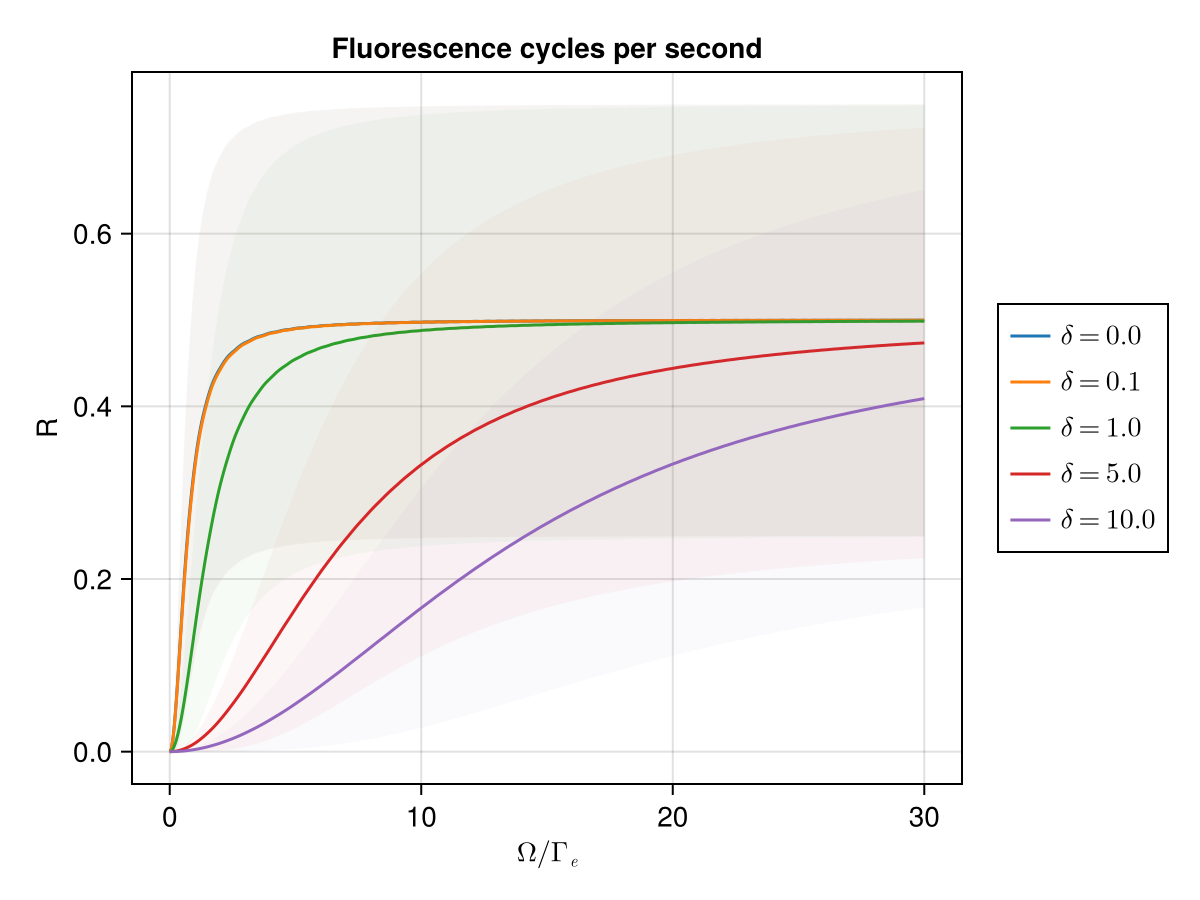

CairoMakie.Screen{IMAGE}


In [61]:

Ωs=0:0.01:30
δs=[0,0.1,1,5,10]

fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\Omega/\Gamma_e", ylabel="R",title="Fluorescence cycles per second")
for (j,δ) in enumerate(δs)
    cycles=[]
    cycles_std=[]
    for (i,Ω) in enumerate(Ωs)
        tout, ρ_master = steadystate.master(H(δ,Ω), J)
        push!(cycles,real(expect(transition(b,2,2),ρ_master[end]))*rates[1])
        push!(cycles_std,real(variance(transition(b,2,2),ρ_master[end]))*rates[1])
    end
    lines!(ax, Ωs, cycles, label=L"\delta=%$δ",color=colors[j])
    #error bars
    band!(ax, Ωs, cycles .- cycles_std, cycles .+ cycles_std, color=colors[j], alpha=0.2)
end
Legend(fig[1,2],ax)
display(fig)

# 2) Fluorescence spectrum

## 2.1) Two-time correlation function $\langle \sigma_+(\tau)\sigma_-(0)\rangle$ for a resonant driving

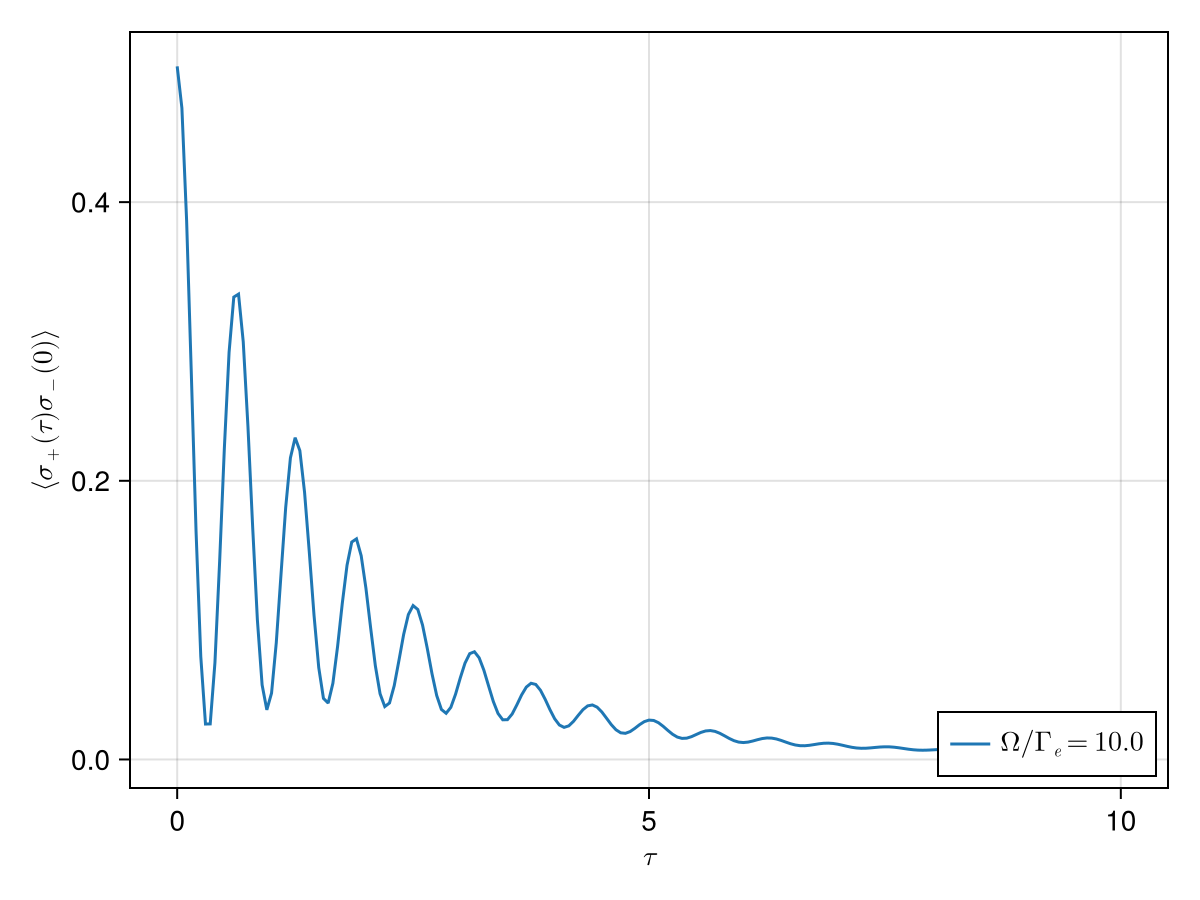

In [93]:
#first we find the steady state
Ω=10
δ=0
tout, ρ_master = steadystate.master(H(δ,Ω), J)
#then we define A(0)
A0=σ_m*ρ_master[end]
#and we compute the time evolution
τspan = 0:0.05:10
tout, At= timeevolution.master(τspan,A0,H(δ,Ω),J,rates=rates)
#expectation value
exp_At=zeros(length(At))
for i in 1:length(At)
    exp_At[i]=real(tr(σ_p*At[i]))
end
#plotting
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\tau", ylabel=L"\langle \sigma_+(\tau)\sigma_-(0)\rangle")
lines!(ax, τspan, exp_At, label=L"\Omega/\Gamma_e = %$(Ω/Γe)",color=colors[1])
axislegend(ax,position=:rb)
fig

## 2.2) Fourrier transform

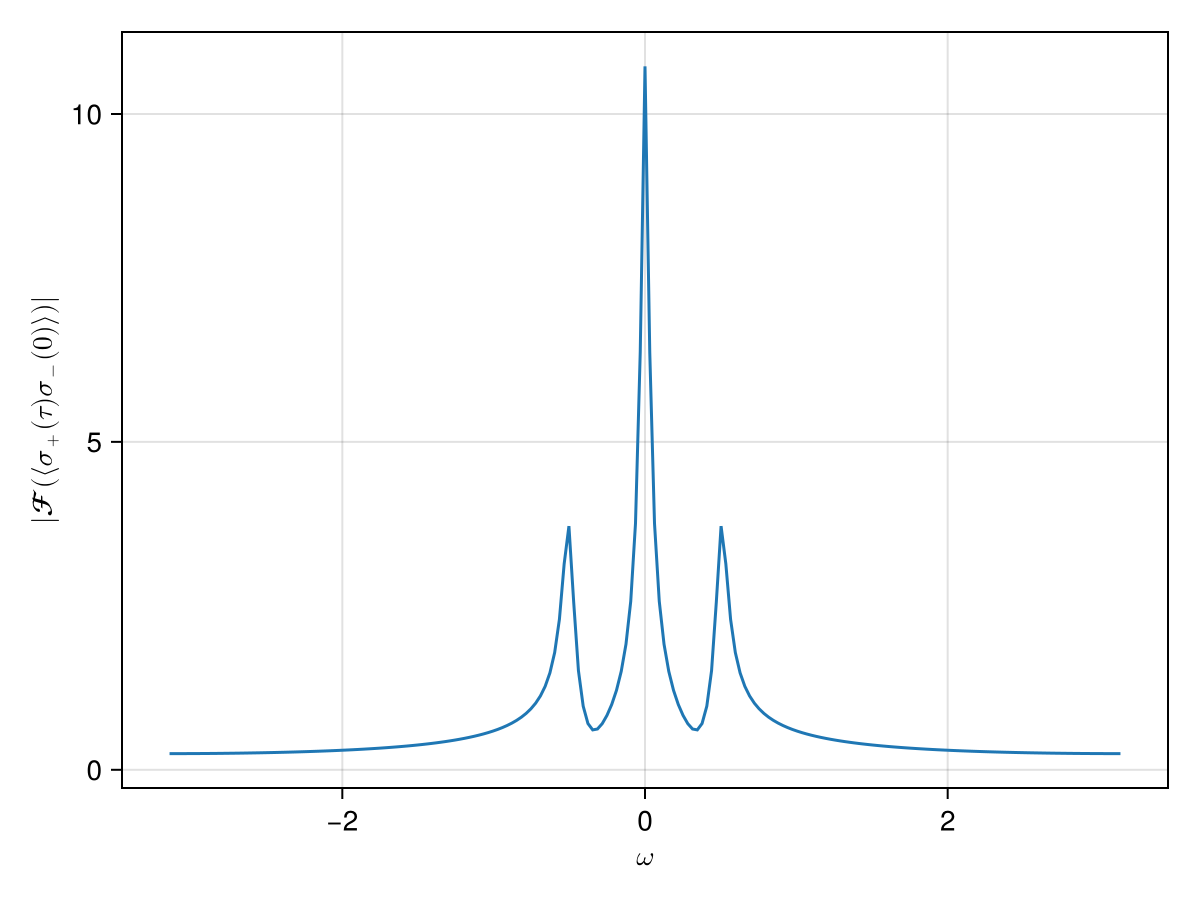

In [94]:
#we compute the Fourier transform of the two-time correlation function
# Fourier transform
freqs = range(-π, π, length=length(exp_At))
FT_exp_At = abs.(fftshift(fft(exp_At)))

# Plotting
fig = Figure()
ax = Axis(fig[1, 1], xlabel=L"\omega", ylabel=L"|\mathcal{F}(\langle \sigma_+(\tau)\sigma_-(0)\rangle)|")
lines!(ax, freqs, FT_exp_At, color=colors[1])
fig

# 3